# Hydrological Data Colection Center
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 21-03-2025<br>

**Introduction:**<br>
This code downloads the stations and time series available in the HYDRO data base.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
import re
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml
import unicodedata

from lisfloodreservoirs.utils import DatasetConfig, APIConfig

def remove_accents(text):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn'
    )

## Configuration

In [2]:
# station filters
TYPE = 'reservoir'
COUNTRY_ID = 'PT' # 'HR'
PROVIDER_ID = None

# # dataset cofiguration
# cfg = DatasetConfig(f'./ResOps{COUNTRY_ID}/config_dataset.yml')

# HDMS API configuration
api = APIConfig('./HDMS_API.yml')

# study period
START = datetime(1979, 1, 1)
END = datetime.now().date()
strftime = '%Y-%m-%dT%H:%M:%S'

# variables of interest
VARIABLES = {
    'river': {
        # 'W': 'water_level',
        'D': 'discharge',
    },
    'reservoir': {
        'I': 'inflow',
        'O': 'outflow',
        'V': 'volume',
        'R': 'level',
    }
}

# directory of the HDMS dataset
PATH_HDMS = Path(f'Z:/nahaUsers/casadje/datasets/hDMS/{TYPE}')

## Stations

In [4]:
service = 'stationsmdv2'

url = f'{api.URL}/{service}/json/' 
if PROVIDER_ID:
    url = f'{url}provider/{PROVIDER_ID}/'
response = requests.get(url, auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))
if response.status_code == 200:
    # convert to pandas
    stations = pd.DataFrame(response.json())
    stations.columns = stations.columns.str.upper()
    stations.set_index('EFAS_ID', drop=True, inplace=True)

    # keep only stations of the specific type
    if TYPE:
        mask_type = stations.TYPE == TYPE.upper()
    else:
        mask_type = True
    # keep only stations in the specific country
    if COUNTRY_ID:
        mask_country = stations['COUNTRY-CODE'] == COUNTRY_ID
    else:
        mask_country = True
    # apply filters
    stations = stations[mask_type & mask_country]

    # organize fields
    stations.dropna(axis=1, how='all', inplace=True)
    stations.drop(['LATITUDE_GEODESIC', 'LONGITUDE_GEODESIC', 'GEODESIC_REFERENCE_SYSTEM', 'VARIABLES', 'CATCHMENT_AREA_UNITS', 'HEIGHT_UNITS', 'TYPE'],
                    axis=1,
                    inplace=True,
                    errors='ignore')
    stations.rename(columns={
         'HAS_RTDATA': 'DATA_RT',
         'HAS_HISTORICAL_DATA': 'DATA_HIST',
         'NATIONAL_STATION_IDENTIFIER': 'LOCAL_ID',
         'PROVIDER_ID': 'PROV_ID',
         'COUNTRY-CODE': 'COUNTRY_ID',
         'BASIN_ENGLISH': 'BASIN_EN',
         'BASIN_LOCAL': 'BASIN_LOC',
         'RIVERNAME_LOCAL': 'RIVER_LOC',
         'RIVERNAME_ENGLISH': 'RIVER_EN',
         'CATCHMENT_AREA': 'CATCH_SKM',
         'LATITUDE_WGS84': 'LAT',
         'LONGITUDE_WGS84': 'LON',
         'COORDINATES_CHECKED': 'COORD_TEST',
         'HEIGHT': 'DAM_HGT_M',
         'HEIGHT_REFERENCE_SYSTEM': 'HEIGHT_RS',
         'LOCAL_REFERENCE_SYSTEM': 'LOCAL_Rs',
         'DATE_OF_STARTING_MEASUREMENT': 'START',
         'DATE_OF_ENDING_MEASUREMENT': 'END',
         'DATE_OF_REGISTRATION': 'REGISTERED',
         'LAST_CHANGE_COMMENT': 'COMMENT_',
         'X-COORDINATE': 'X',
         'Y-COORDINATE': 'Y',
         'CALIBRATION_ID': 'CALIB_ID',
        'DELIVERY_POLICY': 'DELIVERY',
        'INTERNAL_NATIONALSTATIONIDENTIFIER': 'INT_ID',
        'LOCAL_PROJECTION_INFO': 'LOC_PROJ',
        'LOCATION_ON_RIVER_KM': 'RIVER_KM',
        'VERTICAL_DATUM': 'VERT_DATUM'
    }, inplace=True)
    stations.sort_index(axis=1, inplace=True)

    # convert to geopandas
    stations = gpd.GeoDataFrame(
        stations,
        geometry=[Point(xy) for xy in zip(stations.LON, stations.LAT)],
        crs='epsg:4326'
    )

# fix country names
stations.COUNTRY_ID = stations.COUNTRY_ID.str.upper()
stations.COUNTRY = stations.COUNTRY.str.capitalize()
map_countries = {}
for ID in stations.COUNTRY_ID.unique():
    try:
        map_countries[ID] = stations[stations.COUNTRY_ID == ID].COUNTRY.value_counts().index[0]
    except:
        print(ID, 'has no country name associated')
stations.COUNTRY = stations.COUNTRY_ID.map(map_countries)

# treat string columns
col_names = ['NAME', 'BASIN_LOC', 'BASIN_EN', 'RIVER_LOC', 'RIVER_EN']
stations[col_names] = stations[col_names].astype(str).replace('nan', '')
for col in col_names:
    stations[col] = stations[col].str.lower().apply(remove_accents)

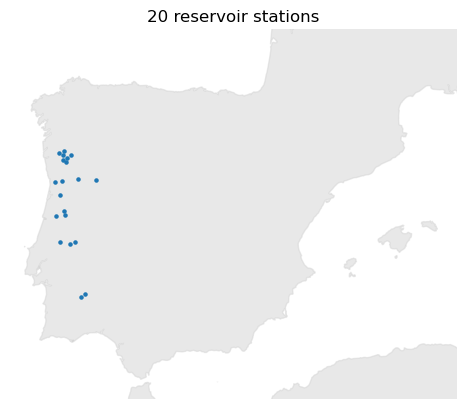

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
stations.plot(markersize=5, ax=ax)
ax.set_title(f'{len(stations)} {TYPE} stations')
ax.set_extent([-10, 5, 35.5, 45])
ax.axis('off');

In [8]:
# export
PATH_GIS = PATH_HDMS / 'GIS'
PATH_GIS.mkdir(parents=True, exist_ok=True)
if PROVIDER_ID:
    shp_file = PATH_GIS / '{0}_HDMS_{1}_{2}.shp'.format(TYPE, PROVIDER_ID, datetime.now().strftime('%Y%m%d'))
elif COUNTRY_ID:
    shp_file = PATH_GIS / '{0}_HDMS_{1}_{2}.shp'.format(TYPE, COUNTRY_ID, datetime.now().strftime('%Y%m%d'))
else:
    shp_file = PATH_GIS / '{0}_HDMS_{1}.shp'.format(TYPE, datetime.now().strftime('%Y%m%d'))
stations.to_file(shp_file)
print(f'Shapefile of stations saved in {shp_file}')

Shapefile of stations saved in Z:\nahaUsers\casadje\datasets\hDMS\reservoir\GIS\reservoir_HDMS_PT_20250321.shp


**Duplicated by distance**

In [ ]:
def find_duplicates(
    gdf: gpd.GeoDataFrame,
    provider_col: str = 'PROV_ID',
    distance_thr: float = 1500
):
    """Finds duplicates in the input GeoDataFrame based on distance (points closer than the threshold) and provider (if they have different provider)
    
    Parameters:
    -----------
    gdf: geopandas.GeoDataFrame
        table of reservoirs/stations in the database
    provider_col: str
        column in "gdf" that defines the provider. Duplicates must have a different provider
    distance_thr: float
        distance below which duplicates can exist. Points further apart than this distance will not be spotted as duplicates. The values depend on the reference coordinate system in "gdf"
        
    Returns:
    --------
    A list of lists with groups of duplicates. The values are the index in "gdf"
    """
    
    duplicates = []
    for ID, point in gdf.geometry.items():
        if any(ID in sublist for sublist in duplicates):
            continue
        
        prov_id = gdf.loc[ID, provider_col]

        # distance to the other reservoirs
        others = gdf[gdf.index != ID]
        distance = others.geometry.distance(point)

        # find close reservoirs
        if distance.min() < distance_thr:
            ids = distance[distance < distance_thr].index.tolist()
            ids = [id for id in ids if gdf.loc[id, provider_col] != prov_id]
            if len(ids) > 0:
                duplicates.append([ID] + ids)
                
    return duplicates

In [ ]:
# find duplicates based on distance and provider
duplicates = find_duplicates(stations, provider_col='PROV_ID', distance_thr=.01667)
print(len(duplicates))

In [ ]:
# export
with open(f"duplicated_{TYPE}.txt", "w") as file:
    for sublist in duplicates:
        file.write(','.join(map(str, sublist)) + '\n')

**Duplicated reservoir names**

In [ ]:
# mapping local and English river names
# river_loc_en = {}
# for river_loc in reservoirs.RIVER_LOC.unique():
#     if river_loc == '':
#         continue
#     mask = reservoirs.RIVER_LOC == river_loc
#     river_en = reservoirs[mask].RIVER_EN.unique().tolist()
#     if '' in river_en:
#         river_en.remove('')
#     if len(river_en) == 0:
#         print(f'No correspondece for river {river_loc}')
#     elif len(river_en) == 1:
#         river_loc_en[river_loc] = river_en[0]
#     else:
#         print(river_loc, river_en)

# # fill in the English river names
# for river_loc, river_en in river_loc_en.items():
#     mask = reservoirs.RIVER_LOC == river_loc
#     reservoirs.loc[mask, 'RIVER_EN'] = river_en

In [ ]:
# find duplicates
res_name_counts = reservoirs.RES_NAME.value_counts()
duplicated_res_name = res_name_counts[res_name_counts > 1].index.tolist()
print(f'{len(duplicated_res_name)} reservoir names are duplicated')

# dictionary that connects duplicated local IDs and EFAS IDs
duplicate_names = {}
for res_name in duplicated_res_name:
    duplicate_names[res_name] = reservoirs.loc[reservoirs.RES_NAME == res_name].index.tolist()

# export
with open('duplicated_res_name.yml', 'w') as file:
    yaml.dump(duplicate_names, file, default_flow_style=False)

In [ ]:
# # summarize data availability
# data_cols = reservoirs.columns[hdcc.columns.str.contains('[O|V|R]_Has_')].tolist()
# reservoirs[data_cols].astype(bool).sum()

***

In [ ]:
reservoirs.COUNTRY_ID.value_counts()

In [ ]:
reservoirs.COUNTRY.value_counts()

In [ ]:
for country in reservoirs.COUNTRY_ID.unique():
    mask = reservoirs.COUNTRY_ID == country
    break

In [ ]:
reservoirs_es = reservoirs[reservoirs.COUNTRY_ID == 'ES']


**Duplicated local ID**

In [ ]:
# find duplicates
local_id_counts = reservoirs_es.LOCAL_ID.value_counts()
duplicated_local_id = local_id_counts[local_id_counts > 1].index.tolist()
print(f'{len(duplicated_local_id)} local IDs are duplicated')

# dictionary that connects duplicated local IDs and EFAS IDs
duplicates_id = {}
for local_id in duplicated_local_id:
    duplicates_id[local_id] = reservoirs_es.loc[reservoirs.LOCAL_ID == local_id].index.tolist()

with open('duplicated_local_id.yml', 'w') as file:
    yaml.dump(duplicates_id, file, default_flow_style=False)

**Duplicated by name**

In [ ]:
reservoirs[mask

In [ ]:
reservoirs.columns

In [ ]:
reservoirs.PROV_ID.value_counts()

***

## Timeseries

In [ ]:
# load stations in Guadiana
stations = gpd.read_file('Z:/nahaUsers/casadje/datasets/hDMS/river/GIS/river_HDMS_20250314.shp').set_index('EFAS_ID', drop=True)
stations = stations[stations.BASIN_EN == 'guadiana']

print(f'{len(stations)} gauging stations')

### Data range

```Python
service = 'hdatarange'
url = f'{api.URL}/{service}/'
response = requests.get(url + '9142', auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))

if response.status_code == 200:
    data = response.json()
    # Do something with the data
else:
    print("Failed to retrieve data from the API")
```

### Operational

In [ ]:
# data must be downloaded in 4 batches due to server limitations
dates = [date.date() for date in pd.date_range(START, END, periods=4)]

services = {
    'NRT': 'noperational24h', # 24 hours NRT operational data
    'HIST': 'nhoperational24hw', # 24 hours historic weighted operational table
}

for name, service in services.items():
    
    # path where the data will be saved
    path_out = PATH_HDMS / service
    path_out.mkdir(parents=True, exist_ok=True)

    pbar = tqdm(stations.index, desc='station', total=stations.shape[0])
    for ID in pbar:

        file_out = path_out / f'{ID}.nc'
        # if file_out.exists():
        #     continue

        # download data
        data = {}
        for var, variable in VARIABLES[TYPE].items(): # for each variable
            if 'serie' in locals():
                del serie
            serie = pd.DataFrame(columns=[ID], dtype=float)
            for i, (st, en) in enumerate(zip(dates[:-1], dates[1:])): # for each batch
                if i > 0:
                    st += timedelta(days=1)           
                url = f'{api.URL}/{service}/{st.strftime(strftime)}/{en.strftime(strftime)}/{ID}/{var}' #'/'
                response = requests.get(url, auth=requests.auth.HTTPBasicAuth(api.USERNAME, api.PASSWORD))

                if response.status_code == 200:
                    if 'message' in response.json():
                        continue
                    serie_i = pd.DataFrame(response.json())
                    if serie_i.shape[0] > 0:
                        serie_i = serie_i[['Timestamp', 'AvgValue']].set_index('Timestamp', drop=True)
                        serie_i.index = pd.to_datetime(serie_i.index)
                        serie_i.columns = [ID]
                        serie = pd.concat((serie, serie_i), axis=0)
            if serie.shape[0] > 0:
                data[variable] = serie.sort_index().copy()

        if len(data) > 0:
            
            # convert to xarray.Dataset
            data = xr.Dataset({var: xr.DataArray(serie, dims=['date', 'ID']) for var, serie in data.items()})

            # export as NetCDF
            data.to_netcdf(file_out)
            print(f'Saved {file_out}')
        else:
            print(f'No data was found for station with EFAS_ID {ID}')

station:   0%|          | 0/20 [00:00<?, ?it/s]

No data was found for station with EFAS_ID 10341
No data was found for station with EFAS_ID 10342
No data was found for station with EFAS_ID 10343
No data was found for station with EFAS_ID 10344
No data was found for station with EFAS_ID 10345
No data was found for station with EFAS_ID 10346
No data was found for station with EFAS_ID 10347
No data was found for station with EFAS_ID 10348
No data was found for station with EFAS_ID 10349
No data was found for station with EFAS_ID 10350
No data was found for station with EFAS_ID 10351
No data was found for station with EFAS_ID 10352
No data was found for station with EFAS_ID 10353
No data was found for station with EFAS_ID 10354
No data was found for station with EFAS_ID 10355
No data was found for station with EFAS_ID 10356
No data was found for station with EFAS_ID 10357
No data was found for station with EFAS_ID 10358
No data was found for station with EFAS_ID 10359
No data was found for station with EFAS_ID 10360


station:   0%|          | 0/20 [00:00<?, ?it/s]

Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10341.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10342.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10343.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10344.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10345.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10346.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10347.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10348.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10349.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10350.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10351.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational24hw\10352.nc
Saved Z:\nahaUsers\casadje\datasets\hDMS\reservoir\nhoperational